In [ ]:
import math
import copy
from functools import partial
from collections import OrderedDict
from typing import Optional, Callable
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import functional as F

# Section A Build EfficientNet

## 1 helper functions

In [ ]:
def _make_divisible(channel, divisor=8,min_ch=None):
    # tune in channel divisible by 8, friendly to hardware
    '''
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    '''
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch,int(channel+divisor/2)//divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * channel:
        new_ch += divisor
    return new_ch

def drop_path(x,drop_prob:float=0.,training:bool=False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf

    This function is taken from the rwightman.
    It can be seen here:
    https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py#L140
    """
    if drop_prob == 0. or not training:
      return x
    
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


## 2 Helper Blocks

In [ ]:
class SEblock(nn.Module): # the squeeze excitation
  def __init__(self,input_c,expand_c,squeeze_factor=4):
    # expand_c is the expanded channel in the MBConv
    super(SEblock,self).__init__()
    squeeze_c = input_c // squeeze_factor
    self.fc1 = nn.Conv2d(expand_c,squeeze_c,1)
    self.ac1 = nn.SiLU()
    self.fc2 = nn.Conv2d(squeeze_c,expand_c,1)
    self.ac2 = nn.Sigmoid()
  
  def forward(self,x:Tensor) -> Tensor:
    out = F.adaptive_avg_pool2d(x,output_size=(1,1))
    out = self.fc1(out)
    out = self.ac1(out)
    out = self.fc2(out)
    out = self.ac2(out)
    return out*x

In [ ]:
class ConvBNActivation(nn.Module):
  # compact Convolution BN and activation together for futuer conveience
    def __init__(self,in_channels,
            out_channels,
            kernel_size = 3,
            stride = 1,
            groups = 1,
            norm_layer:Optional[Callable[...,nn.Module]]=None,
            activation_layer:Optional[Callable[..., nn.Module]]=None):
    # group used to control wether to use depthwise convolution
      super(ConvBNActivation,self).__init__()
      
      padding = (kernel_size - 1)//2

      if norm_layer is None:
        norm_layer = nn.BatchNorm2d
      if activation_layer is None:
        activation_layer = nn.SiLU
    
      self.conv = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                          out_channels = out_channels,
                          kernel_size = kernel_size,
                          stride = stride,
                          padding = padding,
                          groups = groups,
                          bias = False),
                    norm_layer(out_channels),
                    activation_layer())

    def forward(self,x):
      return self.conv(x)

## 3 MBConv

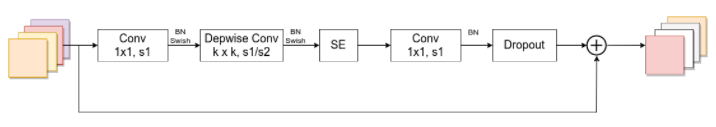


In [ ]:
class MBConv(nn.Module):
  # MBConv1 doesn't have the first 1*1 layer for it doesn't expand the channels
  def __init__(self,kernel_size,in_channels,out_channels,expand_ratio,stride,
               use_se,drop_rate,norm_layer):
    super(MBConv,self).__init__()
    activation_layer = nn.SiLU
    exp_channel = in_channels * expand_ratio

    # expend channel, not activated for MBConv1
    if expand_ratio != 1:
      self.conv1 = ConvBNActivation(in_channels = in_channels,
                      out_channels = exp_channel,
                      kernel_size = 1,
                      norm_layer = norm_layer,
                      activation_layer = activation_layer)
    else: self.conv1 = nn.Identity()

    #Depthwise Conv
    self.Dep_conv = ConvBNActivation(in_channels = exp_channel,
                      out_channels = exp_channel,
                      kernel_size = kernel_size,
                      stride = stride,
                      groups = exp_channel,
                      norm_layer = norm_layer,
                      activation_layer = activation_layer)
    if use_se:
      self.SE = SEblock(in_channels,exp_channel)
    else: self.SE = nn.Identity()

    self.project_conv = ConvBNActivation(in_channels = exp_channel,
                        out_channels = out_channels,
                        kernel_size = 1,
                        norm_layer = norm_layer,
                        activation_layer = activation_layer)
    
    self.use_res_connect = (stride == 1 and in_channels == out_channels)
    if self.use_res_connect:
      # use the dropout if there is an residual connection
      self.dropout = DropPath(drop_rate)
    else:
      self.dropout = nn.Identity()
    
  def forward(self,x:Tensor) -> Tensor:
    out = self.conv1(x)
    out = self.Dep_conv(out)
    out = self.SE(out)
    out = self.project_conv(out)
    out = self.dropout(out)
    if self.use_res_connect: # residual connection
      out = out + x
    return out

## 4 Efficient Net


base structure: 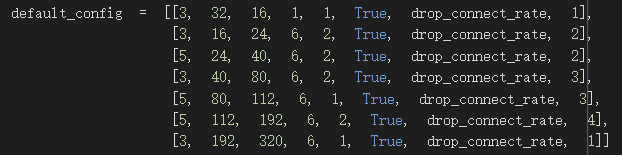

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self,
          in_channels, # variant for our two approaches
          width_coeff, # variant between B0~B7 models, controls #channels
          depth_coeff, # variant between B0~B7 models, controls #blocks
          num_classes,
          dropout_rate = 0.2, # for the laset MLP layer of EfficientNet
          drop_connect_rate = 0.2, # dropout in the MBConv layers
          norm_layer:Optional[Callable[...,nn.Module]] = None
          ):

    super(EfficientNet,self).__init__()

    def round_repeats(repeats):
      # adjust the depth, round numbers of repeats to integers
      return int(math.ceil(depth_coeff * repeats))
    def adjust_channels(channels):
      # adjuct channels according to the width coefficient
      return _make_divisible(channels * width_coeff,8)
    if norm_layer is None:
     norm_layer = nn.BatchNorm2d

    # kernel_size, in_channel, out_channel, exp_ratio, strides, use_SE, drop_connect_rate, repeats
    # dropout increases from 0 to the given value, so need to interpolate while feeding into blocks
    default_config = [[3, 32, 16, 1, 1, True, drop_connect_rate, 1],
              [3, 16, 24, 6, 2, True, drop_connect_rate, 2],
              [5, 24, 40, 6, 2, True, drop_connect_rate, 2],
              [3, 40, 80, 6, 2, True, drop_connect_rate, 3],
              [5, 80, 112, 6, 1, True, drop_connect_rate, 3],
              [5, 112, 192, 6, 2, True, drop_connect_rate, 4],
              [3, 192, 320, 6, 1, True, drop_connect_rate, 1]]
    
    d = 0 #initialize the interpolation index
    num_blocks = 0
    for item in default_config:
      num_blocks += round_repeats(item[-1]) #get the total block number
      #num_blocks = sum(round_repeats(item[-1] for item in default_config)) #get the total block number
    
    Blocks = []
    for i, args in enumerate(default_config):
      cnf = copy.copy(args)
      for j in range(round_repeats(cnf.pop(-1))):
        cnf[1] = adjust_channels(args[1]) # adjust the input channel according width_coeff
        cnf[2] = adjust_channels(args[2]) # adjust the output channel
        if j > 0: # stride is 1 except for first block
          cnf[4] = 1 
          cnf[1] = cnf[2] #input channel equals the output channels from last layer

        cnf[-1] = drop_connect_rate * d / num_blocks # interpolate and upadate dropout
        
        # things we need to feed: 
        # (kernel_size,in_channels,out_channels,expand_ratio,stride,use_se,drop_rate,norm_layer)
        d += 1
        Blocks.append( MBConv(*cnf, norm_layer=norm_layer) )
    
    '''The First Convolution Layer'''
    self.stage1 = ConvBNActivation(in_channels = in_channels,
                    out_channels = adjust_channels(32), #stage 1 default output 32 channels
                    kernel_size = 3,
                    stride = 2,
                    norm_layer = norm_layer)
    
    '''stage 2-8'''
    self.stage2_8 = nn.Sequential(*Blocks)

    '''stage 9'''
    input_c9 = adjust_channels(default_config[-1][2]) # output channel of stage 8
    output_c9 = adjust_channels(1280)
    self.stage9 = nn.Sequential(
                    ConvBNActivation(in_channels = input_c9,
                              out_channels = output_c9,
                              kernel_size = 1,
                              norm_layer = norm_layer),
                    nn.AdaptiveAvgPool2d(1), #remains only channel
                    nn.Flatten(),
                    nn.Dropout(dropout_rate,inplace=True),
                    nn.Linear(output_c9, num_classes)
                    )
    
    # initial weights
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)
    
  def forward(self,x:Tensor) -> Tensor:
    x = self.stage1(x)
    x = self.stage2_8(x)
    x = self.stage9(x)

    return x

## 5 Different Versions of EfficientNet

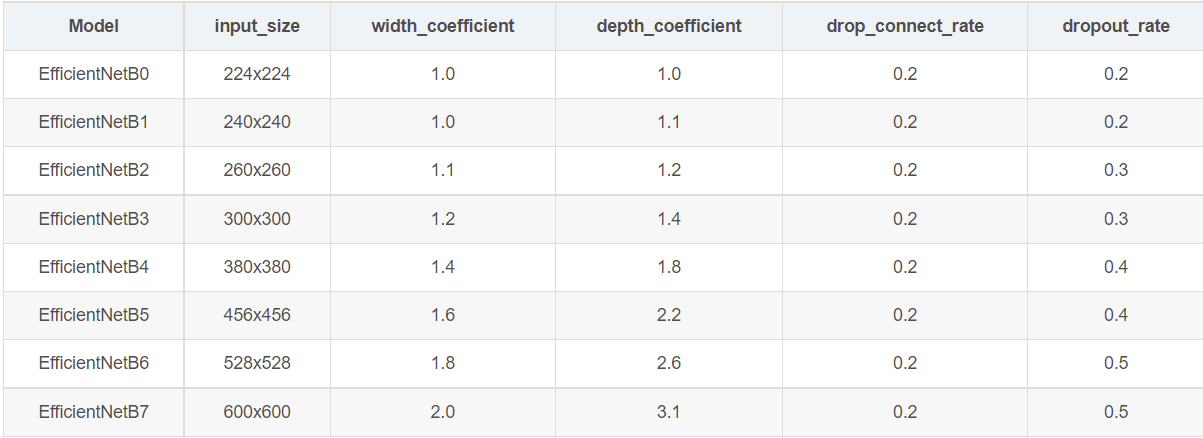

In [ ]:
class EfficientNetVersions:

  def __init__(self,in_channels,num_classes):
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.net = None

  def efficientnet_b0(self):
      # input image size 224x224
    self.net = EfficientNet(in_channels = self.in_channels,
                        width_coeff=1.0,
                        depth_coeff=1.0,
                        dropout_rate=0.2,
                        num_classes=self.num_classes)
    
    return EfficientNet(in_channels = self.in_channels,
                        width_coeff=1.0,
                        depth_coeff=1.0,
                        dropout_rate=0.2,
                        num_classes=self.num_classes)
      
  def efficientnet_b1(self):
      # input image size 240x240
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.0,
                          depth_coefficient=1.1,
                          dropout_rate=0.2,
                          num_classes=self.num_classes)

  def efficientnet_b2(self):
      # input image size 260x260
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.1,
                          depth_coefficient=1.2,
                          dropout_rate=0.3,
                          num_classes=self.num_classes)

  def efficientnet_b3(self):
      # input image size 300x300
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.2,
                          depth_coefficient=1.4,
                          dropout_rate=0.3,
                          num_classes=self.num_classes)

  def efficientnet_b4(self):
      # input image size 380x380
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.4,
                          depth_coefficient=1.8,
                          dropout_rate=0.4,
                          num_classes=self.num_classes)

  def efficientnet_b5(self):
      # input image size 456x456
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.6,
                          depth_coefficient=2.2,
                          dropout_rate=0.4,
                          num_classes=self.num_classes)

  def efficientnet_b6(self):
      # input image size 528x528
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.8,
                          depth_coefficient=2.6,
                          dropout_rate=0.5,
                          num_classes=self.num_classes)

  def efficientnet_b7(self):
      # input image size 600x600
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=2.0,
                          depth_coefficient=3.1,
                          dropout_rate=0.5,
                          num_classes=self.num_classes)
    

In [ ]:
Feature_Extractor = EfficientNetVersions(in_channels=15,num_classes=120)

# Section B DataLoading

In [ ]:
from google.colab import drive
import json
drive.mount('/content/gdrive',force_remount=False)

Mounted at /content/gdrive


In [ ]:
!cp /content/gdrive/MyDrive/converted_224x224.tar.gz /content
%cd /content
!tar -xvzf /content/converted_224x224.tar.gz

In [ ]:
!ls /content/converted_224x224/

## 1 Load Data and Split

In [ ]:
import os
import sys

import numpy as np
import time
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
np.random.seed(0)
df = pd.read_csv("/content/gdrive/MyDrive/3+1.csv")
print(df.shape[0])

train_end = int(len(df)*0.7)
val_end = int(len(df)*0.85)
train_data = df[:train_end]
val_data = df[train_end:val_end]
test_data = df[val_end:]

train_data = train_data.reset_index().drop('Unnamed: 0.1',1).drop('index',1)
val_data = val_data.reset_index().drop('Unnamed: 0.1',1).drop('index',1)
test_data = test_data.reset_index().drop('Unnamed: 0.1',1).drop('index',1)

120360


## 2 DataLoader

In [ ]:
# Define dataset class
class MyDataSet(Dataset):

    # load the dataset
    def __init__(self, data, dir, **kwargs):
        self.X = data["frames"]
        self.Y = data["label"]
        self.dir = dir

    # get number of items/rows in dataset
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        for c in ["(",")",",","'"]:
            x = x.replace(c, "")
        x = x.split(" ")
        images = []
        for img_file in x:
            img = Image.open(self.dir + img_file)
            img = torchvision.transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])(img)
            images.extend(img)
        x = torch.stack(images)
        return x, y
    

In [ ]:
class TestDataSet(Dataset):

    # load the dataset
    def __init__(self, data, dir, **kwargs):
        self.X = data["frames"]
        self.dir = dir
    # get number of items/rows in dataset
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        x = self.X[index]
        for c in ["(",")",",","'"]:
          x = x.replace(c, "")
        x = x.split(" ")
        images = []
        for img_file in x:
            img = Image.open(self.dir + img_file)
            img = torchvision.transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])(img)
            images.extend(img)
        x = torch.stack(images)
        return x

In [ ]:
batch_size = 32
path = 'converted_224x224/'
# training data
train_set = MyDataSet(train_data, path)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4)

# validation data
val_set = MyDataSet(val_data,path)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, num_workers=4)

# test data
test_set = MyDataSet(test_data,path)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=4)

# Section C Training


## 1 build the whole model including MLP

In [ ]:
class MyModel(nn.Module):
  def __init__(self,in_channels,embedding,num_classes):
    super(MyModel,self).__init__()
    CNN = EfficientNetVersions(in_channels = in_channels,
                  num_classes = embedding)
    
    self.cnn = CNN.efficientnet_b0()
    self.mlp = nn.Sequential(nn.Linear(embedding,num_classes)
                  )
  
  def forward(self,x:Tensor) -> Tensor:
    x = self.cnn(x)
    x = self.mlp(x)

    return x

## 2 Training & Validation Epoch


In [ ]:
def train_model(train_loader,train_dataset,model,criterion, optimizer):
    training_loss = 0
    accuracy = 0.0
    # Set model in 'Training mode'
    model.train()
    start_time = time.time()
    
    with tqdm(train_loader) as t:
      for i, (x, y) in enumerate(train_loader):
        t.set_description("Training")
        optimizer.zero_grad()

        # all data & model on same device
        x = x.to(device)
        y = y.to(device)
        # compute the model output
        outputs = model(x)

        num_train_correct = (torch.argmax(outputs, axis=1) == y).sum().item()
        num_labels = len(y)
        accuracy += (num_train_correct/num_labels)

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
       

    end_time = time.time()
    acc = accuracy/len(train_loader)
    training_loss /= len(train_loader)

    return training_loss,acc

# Evaluate the model
def evaluate_model(val_loader, val_dataset, model,criterion):
  with torch.no_grad():
    model.eval()
    val_loss = 0.0
    accuracy = 0
    # Set model in validation mode
    with tqdm(val_loader) as t:
      for i, (x, y) in enumerate(val_loader):
        t.set_description("Evaluating")
         # all data & model on same device
        x = x.to(device)
        y = y.to(device)
        # evaluate the model on the validation set
        outputs = model(x)
        accuracy += (torch.argmax(outputs, axis=1) == y).sum().item() / len(y)
        loss = criterion(outputs, y.long())
        val_loss += loss.item() 

    acc = accuracy/ len(val_loader)
    val_loss /= len(val_loader)
    return val_loss,acc

## 3 Hyperparameters & Training

In [ ]:
embedding = 512
num_classes = 24
in_channels = 12


num_epochs = 20
learningRate = 0.1
weightDecay = 1e-4

model = MyModel(in_channels,embedding,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

print(model)

MyModel(
  (cnn): EfficientNet(
    (stage1): ConvBNActivation(
      (conv): Sequential(
        (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (stage2_8): Sequential(
      (0): MBConv(
        (conv1): Identity()
        (Dep_conv): ConvBNActivation(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
        )
        (SE): SEblock(
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (ac1): SiLU()
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (ac2): Sigmoid()
        )
        (project_conv): ConvBNActivation(
          (conv): Sequential(
            

In [ ]:
base_acc = 0.0
num_epochs = 20
# Define number of epochs
for epoch in range(num_epochs):
    print('='*30)
    # Train
    training_loss, train_acc= train_model(train_loader,train_set,model,criterion, optimizer)
    
    # Validation for validation dataset
    val_loss,val_acc = evaluate_model(val_loader,val_set,model,criterion)

    # scheduler
    scheduler.step(val_loss)
    print("Epoch: ",epoch+1,", current lr:", optimizer.state_dict()['param_groups'][0]['lr'])

    #checkpoint_name = "/content/gdrive/MyDrive/" + str(epoch+1) + ".pt"
    #torch.save(model.state_dict(), checkpoint_name)

    if val_acc > base_acc:
      model_save_name = 'shot_detection.pt'
      torch.save(model.state_dict(), "/content/gdrive/MyDrive/best_model_3+1.pt")
      print("Epoch: "+str(epoch+1)+",saved model parameter")
      base_acc = val_acc
    
    # Print log of training & validate accuracy
    print("Epoch: "+str(epoch+1)+", Training accuracy: "+str(train_acc*100)+"%, Validation accuracy:"+str(val_acc*100)+"%, Training loss: "+str(training_loss)+", Validation loss:"+str( val_loss))

Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch:  1 , current lr: 0.00625
Epoch: 1,saved model parameter
Epoch: 1, Training accuracy: 85.28226900330964%, Validation accuracy:32.56452802359882%, Training loss: 0.38270030413466716, Validation loss:2.8083078253321943


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch:  2 , current lr: 0.00625
Epoch: 2, Training accuracy: 86.79076691443763%, Validation accuracy:32.057522123893804%, Training loss: 0.34605712829277263, Validation loss:2.98786031263592


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch    23: reducing learning rate of group 0 to 3.1250e-03.
Epoch:  3 , current lr: 0.003125
Epoch: 3, Training accuracy: 87.49237019152515%, Validation accuracy:32.07227138643068%, Training loss: 0.32685704309701286, Validation loss:3.0962851444704342


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch:  4 , current lr: 0.003125
Epoch: 4, Training accuracy: 88.98425207530791%, Validation accuracy:32.400442477876105%, Training loss: 0.2894179185083439, Validation loss:3.1928693472547867


Evaluating:   0%|          | 0/565 [01:08<?, ?it/s]


Epoch:  5 , current lr: 0.003125
Epoch: 5, Training accuracy: 89.65228419510606%, Validation accuracy:32.56452802359882%, Training loss: 0.2718155761120259, Validation loss:3.19970439841262


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch    26: reducing learning rate of group 0 to 1.5625e-03.
Epoch:  6 , current lr: 0.0015625
Epoch: 6,saved model parameter
Epoch: 6, Training accuracy: 90.06259833975368%, Validation accuracy:32.72676991150443%, Training loss: 0.2591135341594858, Validation loss:3.3553324991754727


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch:  7 , current lr: 0.0015625
Epoch: 7, Training accuracy: 90.72893494655744%, Validation accuracy:32.616150442477874%, Training loss: 0.24300871784220482, Validation loss:3.3434658670188053


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch:  8 , current lr: 0.0015625
Epoch: 8,saved model parameter
Epoch: 8, Training accuracy: 91.13568851391676%, Validation accuracy:32.774705014749266%, Training loss: 0.23380275393252223, Validation loss:3.3120145948719135


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]


Epoch    29: reducing learning rate of group 0 to 7.8125e-04.
Epoch:  9 , current lr: 0.00078125
Epoch: 9, Training accuracy: 91.13738402691118%, Validation accuracy:32.54240412979351%, Training loss: 0.23369954648030447, Validation loss:3.395210336346542


Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]

Epoch:  10 , current lr: 0.00078125
Epoch: 10, Training accuracy: 91.62721773099668%, Validation accuracy:32.73598820058997%, Training loss: 0.22343940736759174, Validation loss:3.325961601931964


## 4 Testing

In [ ]:
path = "/content/gdrive/MyDrive/best_model_3+1.pt"
check_point = torch.load(path)
model.load_state_dict(check_point)


In [ ]:
test_loss,test_acc = evaluate_model(test_loader,test_set,model,criterion)
print(f'Test Accuracy:{test_acc}')

Evaluating:   0%|          | 0/565 [01:09<?, ?it/s]

Test Accuracy:0.27463126843657815
